<a href="https://colab.research.google.com/github/juanmed/dw_a/blob/main/package_detection_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U --pre tensorflow=="2.2.0"
!pip install wget
!pip install gdown
!pip install zipfile36

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [4]:
!pip install zipfile36
!pip install wget

In [5]:
import pathlib as pl
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import cv2

images_path = "./images"
model_path = "./model"

if not os.path.exists(images_path):
  pl.Path(images_path).mkdir(parents=True, exist_ok=True)
if not os.path.exists(model_path):
  pl.Path(model_path).mkdir(parents=True, exist_ok=True)

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

def download_images():
    base_url = 'https://raw.githubusercontent.com/juanmed/dw_a/main/dll_package_recognition/'
    filenames = ['pkrecog_002_0005.jpg', 'pkrecog_003_0011.jpg', 'pkrecog_004_0010.jpg', 'pkrecog_006_0002.jpg', 'pkrecog_006_0009.jpg', 'pkrecog_006_0019.jpg', 'pkrecog_014_0011.jpg', 'pkrecog_020_0035.jpg', 'pkrecog_027_0003.jpg' , 'pkrecog_031_0006.jpg' , 'pkrecog_035_0011.jpg' ,'pkrecog_040_0016.jpg','pkrecog_045_0020.jpg']
    image_paths = []
    for filename in filenames:
        image_path = tf.keras.utils.get_file(fname=filename,
                                            origin=base_url + filename,
                                            untar=False)
        image_path = pathlib.Path(image_path)
        image_paths.append(str(image_path))
    return image_paths

IMAGE_PATHS = download_images()


In [7]:
import shutil
for img in IMAGE_PATHS:
  if ".jpg" in img:
    shutil.move(img, "./images/" + img.split("/")[-1])

IMAGE_PATHS = os.listdir("./images")
IMAGE_PATHS = ["./images/" + f for f in IMAGE_PATHS if "jpg" in f]


In [ ]:
IMAGE_PATHS

In [ ]:
for img in IMAGE_PATHS:
  image_np = load_image_into_numpy_array(img)
  plt.figure()
  plt.title(img.split("/")[-1])
  plt.imshow(image_np)

gt_dict = {"pkrecog_040_0016.jpg":"프리노즈",
           "pkrecog_006_0009.jpg":"씨콜드",
           "pkrecog_027_0003.jpg":"알러엔",
           "pkrecog_031_0006.jpg":"큐자임",
           "pkrecog_020_0035.jpg":"알러샷",
           "pkrecog_006_0002.jpg":"씨콜드",
           "pkrecog_045_0020.jpg":"코란투",
           "pkrecog_014_0011.jpg":"우루사",
           "pkrecog_002_0005.jpg":"베아제",
           "pkrecog_004_0010.jpg":"씨콜드",
           "pkrecog_006_0019.jpg":"씨콜드",
           "pkrecog_035_0011.jpg":"씨즈날",
           "pkrecog_003_0011.jpg":"베아제"}

In [ ]:
IMAGE_PATHS

In [38]:
%%bash
cd model
rm -rf *

In [ ]:
# Download and extract model
import gdown
# old, all annotations https://drive.google.com/file/d/1r3dpmqPX-Vm3bCkhoAqPOKp6574_RU9p/view?usp=sharing
# final from Amazon Training https://drive.google.com/file/d/11QthlLdkC1u_bfzrECrKyOWSZK3gebL3/view?usp=sharing"
# final from ALLLLL https://drive.google.com/file/d/1zuXr96hfEeUUG1_qQZkLSgt0n1lTsDRs/view?usp=sharing
url = 'https://drive.google.com/uc?id=1zuXr96hfEeUUG1_qQZkLSgt0n1lTsDRs'
output = 'ssd_540x640_batch8.zip'
gdown.download(url, output, quiet=False)

In [40]:
import sys
if sys.version_info >= (3, 6):
    import zipfile
else:
    import zipfile36 as zipfile
# Create a ZipFile Object and load sample.zip in it
with zipfile.ZipFile(output, 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(model_path)

In [14]:
import wget
labelmap_url = "https://raw.githubusercontent.com/juanmed/dw_a/main/dll_package_recognition/label_map.pbtxt"
labelmap_file = wget.download(labelmap_url)

In [ ]:
# Install COCO evaluation tools
%%bash 
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
make
cp -r pycocotools ../../models/research/

In [41]:
import time
import tensorflow as tf 
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = model_path + "/my_model" + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 12.68583083152771 seconds


In [17]:
category_index = label_map_util.create_category_index_from_labelmap(labelmap_file,
                                                                    use_display_name=True)

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import cv2
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
%matplotlib inline

output_path = "./sample_output"

if not os.path.exists(output_path):
  pl.Path(output_path).mkdir(parents=True, exist_ok=True)

for image_path in IMAGE_PATHS[:10]:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.4,
          agnostic_mode=False)

    plt.figure(figsize=(15,15))
    plt.imshow(image_np_with_detections)
    cv2.imwrite(os.path.join(output_path, image_path.split("/")[-1]),cv2.cvtColor(image_np_with_detections, cv2.COLOR_RGB2BGR))

    print('Done')
plt.show()

# sphinx_gallery_thumbnail_number = 2

In [19]:
dir_name = "/content/sample_output"
output_filename="/content/sample_output"
shutil.make_archive(output_filename, 'zip', dir_name)

'/content/sample_output.zip'

#Recognize characters

In [ ]:
%%bash
pip install pytesseract

In [ ]:
%%bash
sudo apt install tesseract-ocr

In [ ]:
%%bash
sudo apt install tesseract-ocr-kor

In [ ]:
%%bash
sudo apt install tesseract-ocr-script-hang

In [ ]:
!pip install scipy imutils pytesseract

In [25]:
%%bash
#pip uninstall opencv-contrib-python opencv-python -y
#pip install opencv-contrib-python

In [26]:
#hola

In [27]:
#!pip install --force-reinstall opencv-contrib-python==4.1.2.30
#!pip install --no-cache --force-reinstall opencv-contrib-python==4.0.0.21

In [46]:
try:
 from PIL import Image
except ImportError:
 import Image
import cv2
import pytesseract
import imutils
from imutils.perspective import four_point_transform
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_local

In [47]:
# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
%%bash
sudo apt-get install -y fonts-nanum fonts-nanum-coding fonts-nanum-extra

In [49]:
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()


In [50]:
mpl.rc('font', family="NanumBarunGothic")

In [ ]:
#fm = mpl.font_manager
mpl.get_cachedir()

In [52]:
%%bash 
cd /root/.cache/matplotlib
rm tex.cache

rm: cannot remove 'tex.cache': Is a directory


In [ ]:
print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())
print ('설정파일 위치: ', mpl.matplotlib_fname())
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
# ttf 폰트 전체갯수
print(len(font_list)) 
f = [f.name for f in fm.fontManager.ttflist]
print(len(font_list))
# 10개의 폰트명 만 출력
f[:10]
[(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]

In [ ]:
!pip install git+git://github.com/jaidedai/easyocr.git

In [55]:
from skimage.morphology import skeletonize
from sklearn.cluster import KMeans
import easyocr

def GetLabels(data,nclust):
    labels=[]  
    kmeans = KMeans(n_clusters=nclust, random_state=0).fit(data)
    means=kmeans.cluster_centers_.mean(axis=1)
    idx = np.argsort(means)
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(nclust)
    for i in range(len(kmeans.labels_)):
        labels.append(lut[kmeans.labels_[i]])
    return (labels,np.sort(means))

def get_image_crop(image, xmin_n, ymin_n, xmax_n, ymax_n, margin_x=0, margin_y=0):
  h,w,d = image.shape
  xmin = int(xmin_n * w)
  ymin = int(ymin_n * h)
  xmax = int(xmax_n * w)
  ymax = int(ymax_n * h)
  return image[ymin - margin_y: ymax + margin_y, xmin - margin_x: xmax + margin_x]

w = []
h = []
for ind, image_path in enumerate(IMAGE_PATHS[:1]):

    print('Running inference for {}... '.format(image_path))
    image_np = load_image_into_numpy_array(image_path)
    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = input_tensor[tf.newaxis, ...]
    detections = detect_fn(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    image_np_with_detections = image_np.copy()

    for i,(box,cl,score) in enumerate(zip(detections['detection_boxes'],detections['detection_classes'],detections['detection_scores'])):
      if score > 0.3:
        if cl == 100: #is char
          title_crop = get_image_crop(image_np_with_detections,box[1],box[0],box[3],box[2], 16, 0)
          title_crop = (skeletonize(cv2.cvtColor(title_crop, cv2.COLOR_RGB2GRAY)//255) * 255).astype(np.uint8)
          for i in range(4):
            plt.figure()
            recog_res = pytesseract.image_to_string(title_crop, lang='kor', config='-psm 8')
            print(recog_res)
            #plt.title(image_path.split("/")[-1] + ", " + str(i))
            plt.title(recog_res)
            #print(image_path.split("/")[-1] + ", " + str(i) + ", " + recog_res)
            plt.imshow(title_crop)
            title_crop=cv2.rotate(title_crop, cv2.ROTATE_90_CLOCKWISE)

        if cl == 5: #is title
          title_crop = get_image_crop(image_np_with_detections,box[1],box[0],box[3],box[2], 16, 16)

          
          #top,bottom,left,right=(1,1,1,1)
          #title_crop	=	cv2.copyMakeBorder(	title_crop, top, bottom, left, right, cv2.BORDER_CONSTANT,value=1	)
          if title_crop.shape[0] > title_crop.shape[1]:
            title_crop=cv2.rotate(title_crop, cv2.ROTATE_90_CLOCKWISE)
          #title_crop = (skeletonize(cv2.cvtColor(title_crop, cv2.COLOR_RGB2GRAY)//255) * 255).astype(np.uint8)
          show = True
          #w.append(title_crop.shape[1])
          #h.append(title_crop.shape[0])
          dim = (380,160)
          title_crop = cv2.resize(title_crop, dim, interpolation = cv2.INTER_AREA)
          if(show):          
            plt.figure()
            plt.title("Original")
            plt.imshow(title_crop)

          
          title_crop = cv2.bilateralFilter(title_crop,9,75,75)
          if(show):          
            plt.figure()
            plt.title("Bilateral Filtered")
            plt.imshow(title_crop, cmap="gray")

          canny_edge = cv2.Canny(title_crop,75,200).astype(np.uint8)
          canny_edge = cv2.dilate(canny_edge, kernel=np.ones((3,3), np.uint8), iterations=2)
          #find contours
          if(show):
            plt.figure()
            plt.title("Canny")
            plt.imshow(canny_edge, cmap="gray")

          contours2, hierarchy = cv2.findContours(canny_edge, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
          print("hierarchy",hierarchy.shape)
          sorted_cnts = sorted(contours2, key=cv2.contourArea)
          areas = np.array([cv2.contourArea(c) for c in contours2])
          kmeans = KMeans(n_clusters=2, random_state=0).fit(areas.reshape(-1,1))
          means = kmeans.cluster_centers_.mean(axis=1)
          #print(means)
          #print(kmeans.labels_)
          contours = contours2 #[c  for (c, label) in zip(contours, kmeans.labels_) if (label == 1)]

          if(show):
            plt.figure()
            plt.hist(areas,bins=4)
          # draw moments
          for c in contours:
            M = cv2.moments(c)
            if M["m00"] == 0:
              M["m00"] = 0.1
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            title_crop	=	cv2.circle(title_crop, (cX,cY), 3, (0,255,0),-1)

          if(show):
            plt.figure()
            plt.title("Original")
            plt.imshow(title_crop, cmap="gray")

          img_contours = np.zeros(canny_edge.shape)
          i = -1
          #for i in range(len(kmeans.labels_)):
          #if kmeans.labels_[i] == 1 and (hierarchy[0][i][-1] == -1):
          img_contours = cv2.drawContours(img_contours, contours, i, (255,255,255), -1, hierarchy=hierarchy, maxLevel = 1)
          img_contours = np.logical_not(img_contours).astype(np.uint8) # invert colors

          if(show):
            plt.figure()
            plt.title("Contours")
            plt.imshow(img_contours, cmap="gray")

          #img_fill = np.zeros(img_contours.shape)
          #cv2.fillPoly(img_fill, contours, (255,255,255))
          #plt.figure()
          #plt.title("Polygon Fill")
          #plt.imshow(img_fill, cmap="gray")

          #title_crop = (skeletonize(img_contours//255) * 255).astype(np.uint8)
          #title_crop = cv2.dilate(title_crop, kernel=np.ones((3,3), np.uint8), iterations=3)

          for i in range(2):
            plt.figure()
            recog_res = pytesseract.image_to_string(img_contours, lang='kor', config='-psm 8')
            print(recog_res.replace("\n","_"))
            image_file = image_path.split("/")[-1]
            if gt_dict[image_file] in recog_res:
              print("** EXITO **")
            reader = easyocr.Reader(['ko','en'], gpu=False) # need to run only once to load model into memory
            result = reader.readtext(title_crop)
            print(result)
            #plt.title(image_path.split("/")[-1] + ", " + str(i))
            plt.title(" Prueba {}".format(i))
            #print(image_path.split("/")[-1] + ", " + str(i) + ", " + recog_res)
            plt.imshow(img_contours, cmap="gray")
            img_contours=cv2.flip(img_contours, -1)
          #cv2.imwrite(os.path.join(output_path, image_path.split("/")[-1]),cv2.cvtColor(image_np_with_detections, cv2.COLOR_RGB2BGR))
    print('Done')
plt.show()

# sphinx_gallery_thumbnail_number = 2

Running inference for ./images/pkrecog_002_0005.jpg... 
Done


# Measure Precision

In [56]:
acc_path = "./acc_images"

if not os.path.exists(acc_path):
  pl.Path(acc_path).mkdir(parents=True, exist_ok=True)

# Download and extract model
# old, all annotations https://drive.google.com/file/d/1r3dpmqPX-Vm3bCkhoAqPOKp6574_RU9p/view?usp=sharing
# final from Amazon Training https://drive.google.com/file/d/1bUTdEV0ZfEie1ZKS_uXhHyjyUa-ouqBt/view?usp=sharing"
# pk46  to 60 https://drive.google.com/file/d/1WeO3ltuoTjaJz6tdGuB_LdiV_KE5MLCx/view?usp=sharing
url = 'https://drive.google.com/uc?id=1WeO3ltuoTjaJz6tdGuB_LdiV_KE5MLCx'
output = 'acc_images.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1WeO3ltuoTjaJz6tdGuB_LdiV_KE5MLCx
To: /content/acc_images.zip
17.8MB [00:00, 56.8MB/s]


'acc_images.zip'

In [57]:
!unzip acc_images.zip > /dev/null

In [59]:
import pandas as pd

img_dir = 'dataset_amazon_3'

IMAGE_PATHS = os.listdir(img_dir)
IMAGE_PATHS = [f for f in IMAGE_PATHS if '.jpg' in f]

gt_labels =  pd.read_csv(os.path.join(img_dir, 'image_names.csv'), index_col= 0)

tess_success = 0
easy_success = 0

for ind, image_path in enumerate(IMAGE_PATHS[:10]):
    print("Processing: {}".format(image_path))
    image_np = load_image_into_numpy_array(os.path.join(img_dir, image_path))
    data = gt_labels[gt_labels['files']==image_path]['names'].tolist()[0]
    for i in range(3):
      #print("Rotation ",i)
      recog_res = pytesseract.image_to_string(image_np, lang='kor', config='-psm 8')
      if data in recog_res:
        tess_success = tess_success + 1
      reader = easyocr.Reader(['ko','en'], gpu=True) # need to run only once to load model into memory
      result = reader.readtext(image_np)
      for detection in result:
        points, text, score = detection
        if data in text:
          easy_success = easy_success +1
      image_np=cv2.rotate(image_np, cv2.ROTATE_90_CLOCKWISE)

print("Tesseract: {}/{}".format(tess_success,len(IMAGE_PATHS)))
print("EasyOCR: {}/{}".format(easy_success,len(IMAGE_PATHS)))

Processing: pkrecog_051_0000.jpg


Processing: pkrecog_070_0000.jpg
Processing: pkrecog_065_0000.jpg
Processing: pkrecog_059_0000.jpg
Processing: pkrecog_056_0000.jpg
Processing: pkrecog_062_0000.jpg
Processing: pkrecog_072_0000.jpg
Processing: pkrecog_046_0000.jpg
Tesseract: 0/8
EasyOCR: 0/8


In [60]:
text = ""
for el in np.unique(gt_labels['names']):
  text = text+"'"+el+"'" + ","
print(text)

'담엔싹','사리돈에이','오메코프에스','콜드펜','타나센','파메콘','펜잘큐','화이투벡',


Processing: pkrecog_051_0000.jpg 오메코프에스
Prediction:  오m고프애스
Done
Processing: pkrecog_070_0000.jpg 콜드펜
Done
Processing: pkrecog_065_0000.jpg 펜잘큐
Done
Processing: pkrecog_059_0000.jpg 타나센
Prediction:  발나센
Done
Processing: pkrecog_056_0000.jpg 담엔싹
Prediction:  담소씩히
Done
Processing: pkrecog_062_0000.jpg 사리돈에이
Prediction:  돈
Done
Processing: pkrecog_072_0000.jpg 파메콘
Prediction:  파메컨
Done
Processing: pkrecog_046_0000.jpg 화이투벡
화이투벡
Done
Tesseract0: 0/8 = 0.0000
EasyOCR0: 5/8 = 0.6250
Tesseract1: 0/8 = 0.0000
EasyOCR1: 2/8 = 0.2500
Tesseract2: 0/8 = 0.0000
EasyOCR2: 0/8 = 0.0000
Tesseract3: 0/8 = 0.0000
EasyOCR3: 0/8 = 0.0000
Tesseract4: 0/8 = 0.0000
EasyOCR4: 0/8 = 0.0000
Tesseract5: 0/8 = 0.0000
EasyOCR5: 0/8 = 0.0000


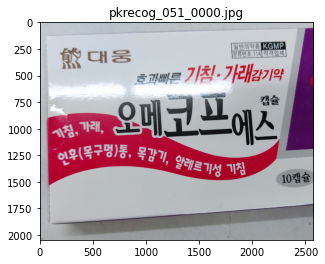

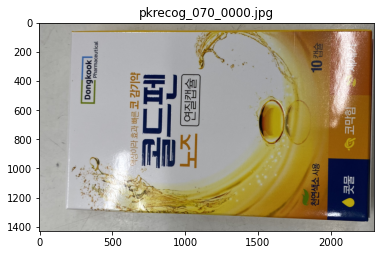

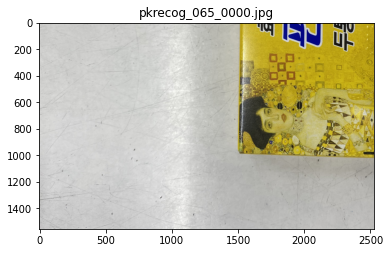

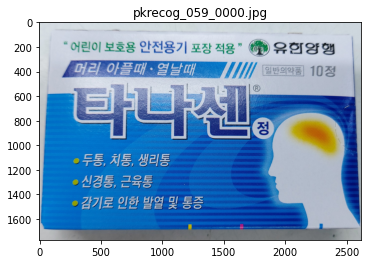

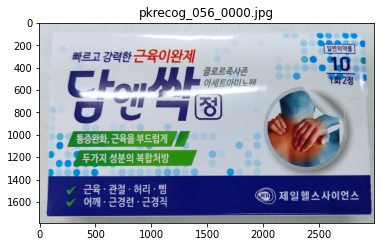

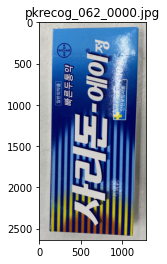

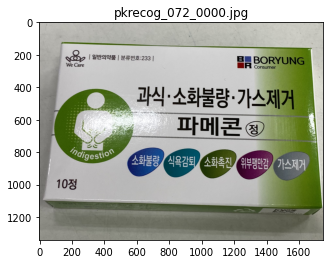

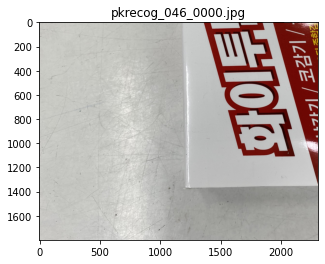

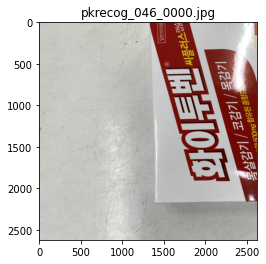

In [64]:
from difflib import SequenceMatcher
tess_success0 = 0
easy_success0 = 0

tess_success1 = 0
easy_success1 = 0

tess_success2 = 0
easy_success2 = 0

tess_success3 = 0
easy_success3 = 0

tess_success4 = 0
easy_success4 = 0

tess_success5 = 0
easy_success5 = 0

tess_rates = []
easy_rates = []

def compare_strings(a,b):
  return SequenceMatcher(None, a, b).ratio()

thresh0 = 0.25
thresh1 = 0.50
thresh2 = 0.75
thresh3 = 0.90
thresh4 = 0.95
thresh5 = 0.99

for ind, image_path in enumerate(IMAGE_PATHS[:]):
    print("Processing: {}".format(image_path), end=" ")
    image_np = load_image_into_numpy_array(os.path.join(img_dir, image_path))
    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = input_tensor[tf.newaxis, ...]
    detections = detect_fn(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    image_np_with_detections = image_np.copy()


    for i,(box,cl,score) in enumerate(zip(detections['detection_boxes'],detections['detection_classes'],detections['detection_scores'])):
      if score > 0.4:
        if cl == 100: #is char
          title_crop = get_image_crop(image_np_with_detections,box[1],box[0],box[3],box[2], 16, 0)
          for i in range(4):
            plt.figure()
            recog_res = pytesseract.image_to_string(title_crop, lang='kor', config='-psm 8')
            print(recog_res)
            plt.title(recog_res)
            plt.imshow(title_crop)
            title_crop=cv2.rotate(title_crop, cv2.ROTATE_90_CLOCKWISE)

        if cl == 3: #is title
          title_crop = get_image_crop(image_np_with_detections,box[1],box[0],box[3],box[2], 16, 16)
          gtlabel = gt_labels[gt_labels['files']==image_path]['names'].tolist()[0]
          print(gtlabel)

          #if title_crop.shape[0] > title_crop.shape[1]:
          #  title_crop=cv2.rotate(title_crop, cv2.ROTATE_90_CLOCKWISE)
          show = True

          #dim = (380,160)
          #title_crop = cv2.resize(title_crop, dim, interpolation = cv2.INTER_AREA)
          if(show):          
            plt.figure()
            plt.title(image_path)
            plt.imshow(title_crop)

          #for i in range(2):
          """
          recog_res = pytesseract.image_to_string(title_crop, lang='kor', config='-psm 8')
          recog_res = recog_res.replace(" ","",-1).replace("\n","/",-1)
          #print("Tesseract: ")
          score = compare_strings(gtlabel,recog_res)
          if score > thresh0:
            tess_success0 += 1
          if score > thresh1:
            tess_success1 += 1
          if score > thresh2:
            tess_success2 += 1
          if score > thresh3:
            tess_success3 += 1
          if score > thresh4:
            tess_success4 += 1
          if score > thresh5:
            tess_success5 += 1
          tess_rates.append(score)
          """
          reader = easyocr.Reader(['ko','en'], gpu=True) # need to run only once to load model into memory
          result = reader.readtext(title_crop, rotation_info=[90,180,270])
          #print("EasyOCR: ",end="")
          for detection in result:
            points, text, score = detection
            score = compare_strings(gtlabel,text)
            if score > thresh0:
              print("Prediction: ",text)
              easy_success0 += 1
            if score > thresh1:
              easy_success1 += 1
            if score > thresh2:
              easy_success2 += 1
            if score > thresh3:
              easy_success3 += 1
            if score > thresh4:
              easy_success4 += 1
            if score > thresh5:
              easy_success5 += 1
            easy_rates.append(score)
          #print()

          #title_crop=cv2.flip(title_crop, -1)

    print('Done')

tess_rate = tess_success0/len(IMAGE_PATHS)
easy_rate = easy_success0/len(IMAGE_PATHS)
print("Tesseract0: {}/{} = {:.4f}".format(tess_success0,len(IMAGE_PATHS),tess_rate))
print("EasyOCR0: {}/{} = {:.4f}".format(easy_success0,len(IMAGE_PATHS),easy_rate))

tess_rate = tess_success1/len(IMAGE_PATHS)
easy_rate = easy_success1/len(IMAGE_PATHS)
print("Tesseract1: {}/{} = {:.4f}".format(tess_success1,len(IMAGE_PATHS),tess_rate))
print("EasyOCR1: {}/{} = {:.4f}".format(easy_success1,len(IMAGE_PATHS),easy_rate))

tess_rate = tess_success2/len(IMAGE_PATHS)
easy_rate = easy_success2/len(IMAGE_PATHS)
print("Tesseract2: {}/{} = {:.4f}".format(tess_success2,len(IMAGE_PATHS),tess_rate))
print("EasyOCR2: {}/{} = {:.4f}".format(easy_success2,len(IMAGE_PATHS),easy_rate))

tess_rate = tess_success3/len(IMAGE_PATHS)
easy_rate = easy_success3/len(IMAGE_PATHS)
print("Tesseract3: {}/{} = {:.4f}".format(tess_success3,len(IMAGE_PATHS),tess_rate))
print("EasyOCR3: {}/{} = {:.4f}".format(easy_success3,len(IMAGE_PATHS),easy_rate))

tess_rate = tess_success4/len(IMAGE_PATHS)
easy_rate = easy_success4/len(IMAGE_PATHS)
print("Tesseract4: {}/{} = {:.4f}".format(tess_success4,len(IMAGE_PATHS),tess_rate))
print("EasyOCR4: {}/{} = {:.4f}".format(easy_success4,len(IMAGE_PATHS),easy_rate))

tess_rate = tess_success5/len(IMAGE_PATHS)
easy_rate = easy_success5/len(IMAGE_PATHS)
print("Tesseract5: {}/{} = {:.4f}".format(tess_success5,len(IMAGE_PATHS),tess_rate))
print("EasyOCR5: {}/{} = {:.4f}".format(easy_success5,len(IMAGE_PATHS),easy_rate))

In [ ]:
for i in [0,0.25,0.5,0.75,0.9]:
  q = np.quantile(tess_rates,q=i)
  print(i,q)

In [ ]:
c = 0
for d in easy_rates:
  if d > 0.3:
    c += 1

print(c,len(easy_rates))

In [ ]:
# Evaluate model
import pathlib as pl

training_path = "./workspace/training_demo"
annotations_path = "./annotations"

if not os.path.exists(training_path+"/images/train"):
  pl.Path(training_path+"/images/train").mkdir(parents=True, exist_ok=True)
if not os.path.exists(training_path+"/test"):
  pl.Path(training_path+"/images/test").mkdir(parents=True, exist_ok=True)
if not os.path.exists(annotations_path):
  pl.Path(annotations_path).mkdir(parents=True, exist_ok=True)

In [ ]:
import wget
dataset_partition_url = "https://raw.githubusercontent.com/juanmed/dw_a/main/dll_package_recognition/dataset_partition.py"
dataset_partition_file = wget.download(dataset_partition_url)

In [ ]:
# get images
#images_url = "https://drive.google.com/file/d/1aXYKA0_-flbqhUfzU8Z7uoB33hvVn-DJ/view?usp=sharing"
import gdown
import shutil
url = 'https://drive.google.com/uc?id=1aXYKA0_-flbqhUfzU8Z7uoB33hvVn-DJ'
output = 'image_pack.zip'
gdown.download(url, output, quiet=False)
shutil.move(output, training_path+"/images/"+output)

In [ ]:
import sys
if sys.version_info >= (3, 6):
    import zipfile
else:
    import zipfile36 as zipfile
# Create a ZipFile Object and load sample.zip in it
with zipfile.ZipFile(training_path+"/images/"+output, 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(training_path+"/images/")

In [ ]:
# Partition the dataset
%%bash
python dataset_partition.py -x -i "./workspace/training_demo/images/pkrecog_006" -o "./workspace/training_demo/images/" -r 0.9

In [ ]:
gen_tf_url = "https://raw.githubusercontent.com/juanmed/dw_a/main/dll_package_recognition/generate_tfrecord.py"
wget.download(gen_tf_url)
anno_path = "./workspace/training_demo/annotations"
if not os.path.exists(anno_path):
  pl.Path(anno_path).mkdir(parents=True, exist_ok=True)

shutil.move(labelmap_file, anno_path+"/"+labelmap_file)


In [ ]:
# Generate .record files
%%bash
python generate_tfrecord.py -x ./workspace/training_demo/images/train -l ./workspace/training_demo/annotations/label_map.pbtxt -o ./workspace/training_demo/annotations/train.record
python generate_tfrecord.py -x ./workspace/training_demo/images/test -l ./workspace/training_demo/annotations/label_map.pbtxt -o ./workspace/training_demo/annotations/test.record

In [ ]:
net_name = "ssd_resnet50_v1_fpn_640x640_coco17_tpu-8"
config_url = "https://raw.githubusercontent.com/juanmed/dw_a/main/dll_package_recognition/{}.config".format(net_name)
config_file = wget.download(config_url)

shutil.move(config_file, model_path + "/" + config_file)
shutil.copy("./models/research/object_detection/model_main_tf2.py","./workspace/training_demo/model_main_tf2.py")

In [ ]:
# Start evaluation
%%bash
cd workspace/training_demo/
python model_main_tf2.py --alsologtostderr --model_dir=models/my_model --pipeline_config_path=model/my_model/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config --checkpoint_dir=model/my_model

In [ ]:
title_crop.shape